In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/luca/GitRepositories/Brancher')

import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
import numpy as np

from brancher.distributions import NormalDistribution, LogNormalDistribution
from brancher.variables import DeterministicVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

In [2]:
# Real model
mu_real = 1.
nu_real = 1.

# Probabilistic model
mu = NormalVariable(0., 2., "mu")
nu = LogNormalVariable(0., 1., "nu")
x = NormalVariable(BF.sin(mu), nu, "x") #TODO: Fix unary operator -
model = ProbabilisticModel([x]) #FIx Repetitions in summary

model.model_summary

,nu_sigma,nu_mu,nu,mu_mean,mu_var,mu,x
Distribution,Deterministic,Deterministic,Log Normal,Deterministic,Deterministic,Normal,Normal
Parents,(),(),"{nu_sigma, nu_mu}",(),(),"{mu_mean, mu_var}","{nu, mu}"
Observed,False,False,False,False,False,False,False


In [3]:
# Print samples
sample = model.get_sample(5)
sample

,nu_sigma,nu_mu,nu,mu_mean,mu_var,mu,x
0,0.541325,0.0,1.505793,0.0,1.854587,-0.980744,-2.085989
1,0.541325,0.0,1.074711,0.0,1.854587,0.790616,2.966426
2,0.541325,0.0,1.116943,0.0,1.854587,-0.257995,-0.393685
3,0.541325,0.0,0.574162,0.0,1.854587,0.037637,0.072135
4,0.541325,0.0,4.567481,0.0,1.854587,-1.017815,-0.517070


In [4]:
# Print samples from single variable
x_sample = x.get_sample(5)
x_sample

,x
0,-0.530550
1,0.117771
2,-0.175579
3,1.959392
4,-0.770996


In [5]:
# Print samples conditional on an input
in_sample = model.get_sample(5, input_values={mu: 100.})
in_sample

,nu_sigma,nu_mu,nu,mu,x
0,0.541325,0.0,5.104825,100.0,-0.804390
1,0.541325,0.0,0.738064,100.0,-0.394259
2,0.541325,0.0,2.733422,100.0,-0.911455
3,0.541325,0.0,0.275191,100.0,0.021307
4,0.541325,0.0,0.740902,100.0,-0.055203


In [6]:
# # Generate data
data = model.get_sample(number_samples=10, input_values={mu: mu_real, nu: nu_real})

# Observe data
x.observe(data)
model.model_summary

,nu_sigma,nu_mu,nu,mu_mean,mu_var,mu,x
Distribution,Deterministic,Deterministic,Log Normal,Deterministic,Deterministic,Normal,Normal
Parents,(),(),"{nu_sigma, nu_mu}",(),(),"{mu_mean, mu_var}","{nu, mu}"
Observed,False,False,False,False,False,False,True


100%|██████████| 800/800 [00:14<00:00, 57.12it/s]


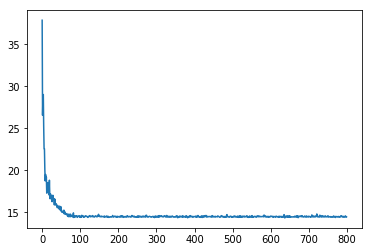

In [7]:
# Variational model
Qmu = NormalVariable(0., 1., "mu", learnable=True)
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

# Inference
inference.stochastic_variational_inference(model,
                                           number_iterations=800,
                                           number_samples=50,
                                           optimizer=chainer.optimizers.Adam(0.05))
loss_list = model.diagnostics["loss curve"]
plt.plot(loss_list)

In [8]:
# print posterior sample
post_sample = model.get_posterior_sample(1000)
post_sample.describe()

,nu,mu,x,mu_mean,mu_var,nu_sigma,nu_mu
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.859434,1.416814,0.944775,1.414536,-1.643634,-0.642761,-0.223288
std,0.361819,0.428753,0.980809,0.000000,0.000000,0.000000,0.000000
min,0.236694,-0.035777,-3.185262,1.414536,-1.643634,-0.642761,-0.223288
25%,0.586984,1.124058,0.302945,1.414536,-1.643634,-0.642761,-0.223288
50%,0.795361,1.419382,0.916860,1.414536,-1.643634,-0.642761,-0.223288
75%,1.041246,1.708841,1.566547,1.414536,-1.643634,-0.642761,-0.223288
max,2.359881,2.592623,4.902062,1.414536,-1.643634,-0.642761,-0.223288


(-5, 5)

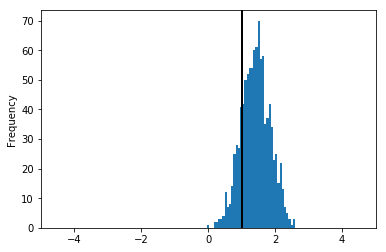

In [9]:
post_sample["mu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=mu_real, c="k", lw=2)
plt.xlim(-5,5)

(0, 6)

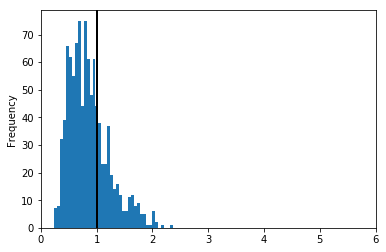

In [10]:
post_sample["nu"].plot.hist(stacked=False, bins=40)
plt.axvline(x=nu_real, c="k", lw=2)
plt.xlim(0,6)

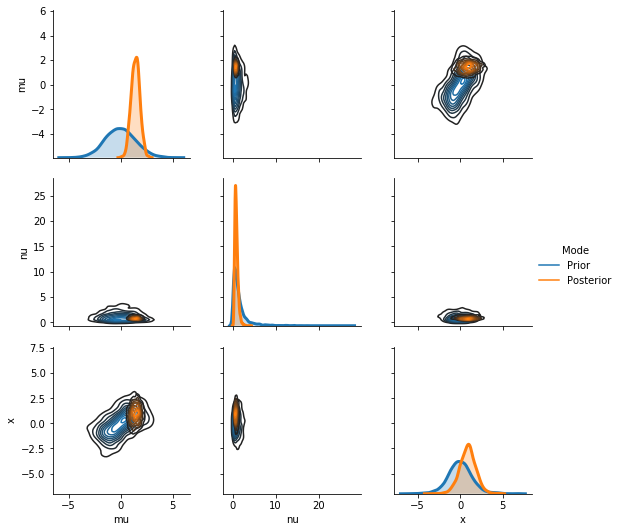

In [11]:
from brancher.visualizations import plot_posterior

plot_posterior(model, variables=["mu", "nu", "x"])